# Parallel and Larger-than-Memory Processing

**Authors:** Ian Carroll (NASA, UMBC)

<div class="alert alert-success" role="alert">

The following notebooks are **prerequisites** for this tutorial.

- Learn with OCI: [Data Access][oci-data-access]
- Learn with OCI: [Processing with Command-line Tools][oci-ocssw-processing]

</div>

## Summary

Processing a whole collection of Ocean Color Instrument (OCI) granules, or even big subsets of that collection,
requires breaking up one big job into many small jobs. That and putting the pieces back together again. The reason we
break up big jobs has to do with computational resources, specifically memory (i.e. RAM) and processors (i.e. CPUs or GPUs).
That big collection of OCI granules can't all fit in memory; and even if it could, your computation might only use one
of several available processors.

This notebook works towards a better understanding of a tool tightly integrated with XArray that is designed to handle the
challenges of effectively creating and managing these jobs. The tool is [Dask: a Python library for parallel and distributed computing][dask].
Before diving into Dask, the notebook gets started with an even more foundational concept for performant computing: using
compiled functions that are typically not even written in Python.

## Learning Objectives

At the end of this notebook you will know:

- The importance of using high-performance functions to do array operations
- How to start a `dask` client for parallel and larger-than-memory pipelines
- One method for interpolating Level-2 "swath" data to a map projection

## Contents

1. [Setup](#1.-Setup)
2. [Compiled Functions](#2.-Compiled-Functions)
3. [Split-Apply-Combine](#3.-Split-Apply-Combine)
4. [Stacking Level-2 Granules](#4.-Stacking-Level-2-Granules)

[oci-data-access]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci_data_access
[oci-ocssw-processing]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci-ocssw-processing
[dask]: https://docs.dask.org

## 1. Setup

Begin by importing all of the packages used in this notebook. If your kernel uses an environment defined following the guidance on the [tutorials] page, then the imports will be successful.

[tutorials]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/

In [1]:
import dask.array as da
from   dask.distributed import Client
import cartopy.crs as ccrs
import earthaccess
from   matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numba
import numpy as np
import pyproj
from   scipy.interpolate import griddata
import xarray as xr
from   xarray.backends.api import open_datatree

We will discuss `dask` in more detail below, but we use several additional packages that are worth their own tutorials:
- `scipy` is a massive collection of useful numerical methods, including a function that resamples irregularly spaced values onto regular (i.e. gridded) coordinates
- `numba` can convert many Python functions to make them run faster
- `pyproj` is a database and suite of algorithms for converting between geospatial coordinate reference systems

[SatPy](https://satpy.readthedocs.io/) is another Python package that could be useful for the processing demonstrated in this notebok, especially through its [Pyresample](https://pyresample.readthedocs.io/) toolking. SatPy requires dedicated readers for any given instrument, however, and no readers have been created for PACE.

Yet another package we are skipping over is [rasterio](https://rasterio.readthedocs.io/), which is a high-level wrapper for GDAL. Unfortuneately, the GDAL tooling for using "warp" with geolocation arrays has not been released in `rasterio.warp`.

The data used in the demonstration is the `chlor_a` product found in the BGC suite of Level-2 ocean color products from OCI.

In [2]:
bbox = (-77, 36, -73, 41)
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=(None, "2024-07"),
    bounding_box=bbox,
)
len(results)

238

The search results include all granules from launch through July of 2024 that intersect a bounding box around the Chesapeake and Delaware Bays. The region is much smaller than an OCI swath, so we do not use the cloud cover search filter which considers the whole swath.

In [3]:
results[0]

Collection: {'Version': '2.0', 'ShortName': 'PACE_OCI_L2_BGC_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 55.75354, 'Longitude': -44.76188}, {'Latitude': 49.15591, 'Longitude': -83.8102}, {'Latitude': 32.45877, 'Longitude': -73.21217}, {'Latitude': 37.99386, 'Longitude': -44.237}, {'Latitude': 55.75354, 'Longitude': -44.76188}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-03-05T16:32:22Z', 'EndingDateTime': '2024-03-05T16:37:21Z'}}
Size(MB): 12.187410354614258
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240305T163222.L2.OC_BGC.V2_0.NRT.nc']

In [4]:
paths = earthaccess.open(results[:1])

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
datatree = open_datatree(paths[0])
dataset = xr.merge(datatree.to_dict().values())
dataset = dataset.set_coords(("latitude", "longitude"))
dataset

<xarray.Dataset> Size: 70MB
Dimensions:           (number_of_bands: 286, number_of_reflective_bands: 286,
                       number_of_lines: 1710, pixels_per_line: 1272)
Coordinates:
    longitude         (number_of_lines, pixels_per_line) float32 9MB ...
    latitude          (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/28)
    wavelength        (number_of_bands) float64 2kB ...
    vcal_gain         (number_of_reflective_bands) float32 1kB ...
    vcal_offset       (number_of_reflective_bands) float32 1kB ...
    F0                (number_of_reflective_bands) float32 1kB ...
    aw                (number_of_reflective_bands) float32 1kB ...
    bbw               (number_of_reflective_bands) float32 1kB ...
    ...                ...
    carbon_phyto      (number_of_lines, pixels_per_line) float32 9MB ...
    poc               (number_of_lines, pixels_per_line) float32 9MB ...
    chlor_a_unc       (number_of_lines, pixels_per_line) float32 9MB ...
    carbon_phyto_unc  (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags          (number_of_lines, pixels_per_line) int32 9MB ...
    tilt              (number_of_lines) float32 7kB ...
Attributes: (12/45)
    title:                             OCI Level-2 Data BGC
    product_name:                      PACE_OCI.20240305T163222.L2.OC_BGC.V2_...
    processing_version:                2.0
    history:                           l2gen par=/data10/sdpsoper/vdc/vpu9/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -44.237003
    geospatial_lon_min:                -83.810196
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.0161924362182617

As a reminder, the Level-2 data has latitude and longitude arrays that give the geolocation of every pixel. The `number_of_line` and `pixels_per_line` dimensions don't have any meaningful coordinates that would be useful for stacking Level-2 files over time.  In a lot of the granules, like the one visualized here, there will be a tiny amount of data within the box. But we don't want to lose a single pixel (if we can help it)!

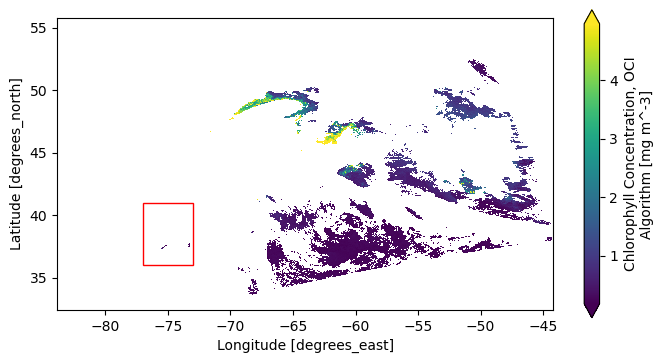

In [6]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_subplot()
artist = dataset["chlor_a"].plot.pcolormesh(x="longitude", y="latitude", robust=True, ax=axes)
axes.add_patch(Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="red", facecolor="none"))
axes.set_aspect("equal")
plt.show()

When we get to opening mulitple datasets, we will use a helper function to prepare the datasets for concatenation.

In [7]:
def time_from_attr(ds):
    """Set the time attribute as a dataset variable

    Args:
        ds: a dataset corresponding to a Level-2 granule

    Returns:
        the dataset with a scalar "time" coordinate
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["time"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("time")
    return ds

def trim_number_of_lines(ds):
    ds = ds.isel({"number_of_lines": slice(0, 1709)})
    return ds

Before we get to data, we will play with some random numbers. Whenever you use random numbers, a good practice is to set a fixed but unique seed, such as the result of `secrets.randbits(64)`.

In [8]:
random = np.random.default_rng(seed=5179916885778238210)

[back to top](#Contents)

## 2. Compiled Functions

Before diving in to OCI data, we should discuss two important considerations for when you are trying to improve performance (a.k.a. your processing is taking longer than you would like).

1. Am I using compiled functions?
2. Can I use compiled functions in a split-apply-combine pipeline?

When you wrie a function in Python, there is not usually any compilation step like you encounter when writing functions in C/C++ or Fortran. Compilation converts code written in a human-readable language to a machine-readable language. It does this once, and then you use the resulting compiled function
repeatedly. That does not happen in Python for added flexibility and ease of programming, but it has a performance cost.

A simple way to measure performance (i.e. speed) in notebooks is to use the [IPython %%timeit magic][timeit]. Begin any cell
with `%%timeit` on a line by itself to trigger that cell to run many times under a timer and print a summary
of how long it takes the cell to run on average.

[timeit]: https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit

In [9]:
%%timeit
n = 10_000
x = 0
for i in range(n):
    x = x + i
x / n

817 μs ± 289 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The for-loop in that example could be replaced with a compiled function that calculates the mean of a range.
Python is an interpretted language; there is no step during evaluation that compiles code written in Python
to a lower-level language for your operating system. However, we can call functions from packages that
are already compiled, such as the `numpy.mean` function. In fact, we can even use the `numba` "just-in-time"
compiler to make our own compiled functions.

When you are interested in performance improvements for data processing, the first tool
in your kit is compiled functions. If you use NumPy, you have already checked this box.
However, since you may sometimes need `numba`, we're going to start with a comparison
of functions written in and interpreted by Python with the use of compiled functions.

In [10]:
def mean_and_std(x):
    """Compute sample statistics with a for-loop.

    Args:
      x: One-dimensional array of numbers.

    Returns:
      A 2-tuple with the mean and standard deviation.
    """    
    # initialize sum (s) and sum-of-squares (ss)
    s = 0
    ss = 0
    # calculate s and ss by iterating over x
    for i in x:
        s += i
        ss += i**2
    # mean and std. dev. calculations
    n = x.size
    mean = s / n
    variance = (ss / n - mean ** 2) * n / (n - 1)
    return mean, variance ** (1/2)

Confirm the function is working; it should return approximations to
the mean and standard deviation parameters of the normal
distribution we use to generate the sample.

In [11]:
array = random.normal(1, 2, size=100)
mean_and_std(array)

(0.7304780296630995, 2.0301283010773026)

The approximation isn't very good for a small sample! We are motivated
to use a very big array, say $10^{4}$ numbers, and will compare performance
using different tools.

In [12]:
array = random.normal(1, 2, size=10_000)

In [13]:
%%timeit
mean_and_std(array)

2.84 ms ± 197 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


On this system, the baseline implementation takes between 2 and 3 milliseconds. The `numba.njit` method
will attempt to compile a Python function and raise an error if it can't. The argument to `numba.njit`
is the Python function, and the return value is the compiled function.

In [14]:
compiled_mean_and_std = numba.njit(mean_and_std)

The actual compilation does not occur until the function is called with an argument. This is how mahine-language works, it needs to
know the type of data coming in before any performance improvements can be realized. As a result, the first call to `compiled_mean_and_std`
will not seem very fast.

In [15]:
compiled_mean_and_std(array)

(1.0084849501238558, 1.9962951466599286)

But now look at that function go!

In [16]:
%%timeit
compiled_mean_and_std(array)

15.9 μs ± 1.08 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


But why write your own functions when an existing compiled function can do what you need well enough?

In [17]:
%%timeit
array.mean(), array.std(ddof=1)

59.6 μs ± 15.4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The takeaway message from this brief introduction is:
- `numpy` is fast because it uses efficient, compiled code to do array operations
- `numpy` may not have a function that does exactly what you want, so you do have `numba.njit` as a fallback

Living with what `numpy` can already do is usually good enough, even if a custom function could have a small edge in performance. Moreover, what you
can do with `numpy` you can do with `dask.array`, and that opens up a lot of opportunity for processing large amounts of data without
writing your own numerical methods.

[back to top](#Contents)

## 3. Split-Apply-Combine

The split-apply-combine framework is everywhere in data processing. A simple case is computing group-wise means on a dataset where one variable defines the group and another variable is what you need to average for each group.

1. **split**: divide the array into smaller arrays, one for each group
2. **apply**: calculte the mean
3. **combine**: reassemble the results into a single (smaller due to aggregation) dataset

The same framework is also used without a natural group by which a dataset should be divided. The split is on equal-sized slices of the original dataset, which we call "chunks". Rather than a group-wise mean, you could use "chunk-apply-combine" to calculate the grand mean in chunks

1. **chunk**: divide the array into smaller arrays, or "chunks"
2. **apply**: calculate the mean and sample size of each chunk (i.e. skipping missing values)
3. **combine**: combine the size-weighted means to compute the mean of the whole array

The apply and combine steps have to be capable of calculating results on a slice that can be combined to equal the result you would have gotten on the full array. If a computation can be shoved through "chunk-apply-combine" (see also "map-reduce"), then we can process an array that is too big to read into memory at once. We can also distribute the computation across processors or across a cluster of computers.

We can represent the framework visually using a task graph, a collection of functions (nodes) linked through input and output data (edges).

```mermaid
flowchart LR

A(random.normal) -->|array| B(mean_and_std)
```

The output of the `random.normal` function becomes the input to the `mean_and_std` function. We can decide to use chunk-apply-combine
if either:

1. `array` is going to be larger than available memory
1. `mean_and_std` can be accurately calculated from intermediate results on slices of `array`

By the way, `numpy` arrays have an `nbytes` attribute that helps you understand how much memory you may need. Note tha most computations require several times the size of an input array to do the math.

In [18]:
f"{array.nbytes / 2**20} MiB"

'0.0762939453125 MiB'

That's not a big array. Here's a "big" 1.0 GiB array.

In [19]:
array = random.normal(1, 2, size=2**27)
print(f"{array.nbytes / 2**30} GiB")

1.0 GiB


It's still not too big to fit in memory on most laptops. For demonstration, let's assume we could fit a 1.0 GiB array into memory, but not a 3 GiB array. We will calculate the mean of a 3 GiB array, using 3 splits each of size 1 GiB in a serial pipeline. (Simultaneously calculating the standard deviation is left as an exercise for the reader.)

On this system, the serial approach takes between 8 and 9 seconds.

In [20]:
%%timeit

n = 3
s = 0
for _ in range(n):
    array = random.normal(1, 2, size=2**27)
    s += array.mean()
mean = s / n

8.96 s ± 525 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


All we were able to implement was serial computation, but we have multiple processors availble. When we visualize the task graph for the computation, it's apparent that running the calculation serially might not have been the most performant strategy.

```mermaid
%%{ init: { 'flowchart': { 'curve': 'monotoneY' } } }%%

flowchart LR

A(random.normal) -->|array| B(split)
B -->|array_0| C0(apply-mean_and_std)
B -->|array_1| C1(apply-mean_and_std)
B -->|array_2| C2(apply-mean_and_std)
subgraph SCHEDULER
C0
C1
C2
end
C0 -->|result_0| D(combine-mean_and_std)
C1 -->|result_1| D
C2 -->|result_2| D
```

In this task graph, the `mean_and_std` deviation function is never used! Somehow, the `apply-mean_and_std` function and `combine-mean_and_std` deviation functions have to be defined. This is another part of what Dask provides.

In [21]:
client = Client(processes=False, memory_limit="3 GiB")
client

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46117 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/itcarroll/proxy/46117/status,
Dashboard: /user/itcarroll/proxy/46117/status,Workers: 1
Total threads: 4,Total memory: 3.00 GiB
Status: running,Using processes: False
Comm: inproc://192.168.4.183/1190/1,Workers: 1
Dashboard: /user/itcarroll/proxy/46117/status,Total threads: 4
Started: Just now,Total memory: 3.00 GiB
Comm: inproc://192.168.4.183/1190/4,Total threads: 4
Dashboard: /user/itcarroll/proxy/41675/status,Memory: 3.00 GiB
Nanny: None,


In [22]:
dask_random = da.random.default_rng(random)

In [23]:
dask_array = dask_random.normal(1, 2, size=3*2**27, chunks="32 MiB")
dask_array

dask.array<normal, shape=(402653184,), dtype=float64, chunksize=(4194304,), chunktype=numpy.ndarray>

In [24]:
dask_array.mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [25]:
%%timeit
mean = dask_array.mean().compute()

4.13 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We just demonstrated two ways of doing larger-than-memory calculations.

Our synchronous implemenation (using a for loop) took the strategy of maximizing the use of available memory while processing one chunk: so we used 1 GiB chunks, requiring 3 chunks to get to a 3 GiB array.

Our concurrent implementation (using `dask.array`), took the strategy of maximizing the use of available processors: so we used small chunks of 32 MiB, requiring many chunks to get to a 3 GiB array.

The concurrent implementation was a little more than twice as fast.

In [26]:
client.close()

[back to top](#Contents)

## 4. Stacking Level-2 Granules

The integration of XArray and Dask is designed to let you work without doing very much different. Of course, there is still a lot of work to do when writing any processing
pipeline on a collection of Level-2 granules. Stacking them over time, for instance, may
sound easy but requires resampling the data to a common grid. This section demonstrates
one method for stacking Level-2 granules.

1. Choose a projection for a common grid
1. Get geographic coordinates that correspond to the projected coordinates
1. Resample each granule to the new coordinate
1. Stack results along the time dimension

Use `pyproj` for the first two steps, noting that the EPSG code of the coordinate reference system (CRS) of the Level-2 files is not recorded in the files. Know that it is the universal default for a CRS with latitudes and longitudes: "EPSG:4326".

In [27]:
aoi = pyproj.aoi.AreaOfInterest(*bbox)

In [28]:
pyproj.CRS.from_epsg(4326)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The `pyproj` database contains all the UTM grids and helps us choose the best one for our AOI.

In [29]:
crs_list = pyproj.database.query_utm_crs_info(datum_name="WGS 84", area_of_interest=aoi, contains=True)
for i in crs_list:
    print(i.auth_name, i.code, ": ", i.name)

EPSG 32618 :  WGS 84 / UTM zone 18N


In [30]:
pyproj.CRS.from_epsg(32618)

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Note that the axis order for EPSG:4326 is ("Lat", "Lon"), which is "backwards" from the "X", "Y" used by EPSG:32618. When we use a CRS transformer, this defines the order of arguments.

In [31]:
t = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:32618", area_of_interest=aoi)

In [32]:
x_min, y_min = t.transform(aoi.south_lat_degree, aoi.west_lon_degree)
x_min, y_min

(319733.3418776203, 3985798.2082585823)

In [33]:
x_max, y_max = t.transform(aoi.north_lat_degree, aoi.east_lon_degree)
x_max, y_max

(668207.8851938072, 4540683.529276577)

Create x, y grid as a new `xarray.Dataset` but then `stack` it into a 1D array of points.

In [34]:
x_size = int((x_max - x_min) // 1000)
y_size = int((y_max - y_min) // 1000)
grid_point = xr.Dataset({
    "x": ("x", np.linspace(x_min, x_max, x_size)),
    "y": ("y", np.linspace(y_min, y_max, y_size))
})
grid_point = grid_point.stack({"point": ["x", "y"]})
grid_point

<xarray.Dataset> Size: 5MB
Dimensions:  (point: 192792)
Coordinates:
  * point    (point) object 2MB MultiIndex
  * x        (point) float64 2MB 3.197e+05 3.197e+05 ... 6.682e+05 6.682e+05
  * y        (point) float64 2MB 3.986e+06 3.987e+06 ... 4.54e+06 4.541e+06
Data variables:
    *empty*

To find corresponding latitudes and longitudes in "EPSG:4326", do the inverse transformation paying attention to the order of arguments and outputs.

In [35]:
lat, lon = t.transform(grid_point["x"], grid_point["y"], direction="INVERSE")

In [36]:
grid_point["lat"] = ("point", lat)
grid_point["lon"] = ("point", lon)
grid_point

<xarray.Dataset> Size: 8MB
Dimensions:  (point: 192792)
Coordinates:
  * point    (point) object 2MB MultiIndex
  * x        (point) float64 2MB 3.197e+05 3.197e+05 ... 6.682e+05 6.682e+05
  * y        (point) float64 2MB 3.986e+06 3.987e+06 ... 4.54e+06 4.541e+06
Data variables:
    lat      (point) float64 2MB 36.0 36.01 36.02 36.03 ... 40.98 40.99 41.0
    lon      (point) float64 2MB -77.0 -77.0 -77.0 -77.0 ... -73.0 -73.0 -73.0

In [37]:
grid_latlon = grid_point.to_dataarray("axis").transpose("point", ...)

Instead of opening a single granule with `xr.open_dataset`, open all of the granules with `xr.open_mfdataset`. Use the `time_from_attr` function defined above to populate a `time` coordinate from the attributes on each granule.

In [38]:
paths = earthaccess.open(results[10:20])

QUEUEING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
kwargs = {"combine": "nested", "concat_dim": "time"}
prod = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)
nav = xr.open_mfdataset(paths, preprocess=trim_number_of_lines, group="navigation_data", **kwargs)
sci = xr.open_mfdataset(paths, preprocess=trim_number_of_lines, group="geophysical_data", **kwargs)
dataset = xr.merge((prod, nav, sci))
dataset

<xarray.Dataset> Size: 696MB
Dimensions:           (time: 10, number_of_lines: 1709, pixels_per_line: 1272)
Coordinates:
  * time              (time) datetime64[ns] 80B 2024-03-09T17:14:28.146000 .....
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    longitude         (time, number_of_lines, pixels_per_line) float32 87MB dask.array<chunksize=(1, 256, 1272), meta=np.ndarray>
    latitude          (time, number_of_lines, pixels_per_line) float32 87MB dask.array<chunksize=(1, 256, 1272), meta=np.ndarray>
    tilt              (time, number_of_lines) float32 68kB dask.array<chunksize=(1, 32), meta=np.ndarray>
    chlor_a           (time, number_of_lines, pixels_per_line) float32 87MB dask.array<chunksize=(1, 256, 1272), meta=np.ndarray>
    carbon_phyto      (time, number_of_lines, pixels_per_line) float32 87MB dask.array<chunksize=(1, 256, 1272), meta=np.ndarray>
    poc               (time, number_of_lines, pixels_per_line) float32 87MB dask.array<chunksize=(1, 256, 1272), meta=np.ndarray>
    chlor_a_unc       (time, number_of_lines, pixels_per_line) float32 87MB dask.array<chunksize=(1, 256, 1272), meta=np.ndarray>
    carbon_phyto_unc  (time, number_of_lines, pixels_per_line) float32 87MB dask.array<chunksize=(1, 256, 1272), meta=np.ndarray>
    l2_flags          (time, number_of_lines, pixels_per_line) int32 87MB dask.array<chunksize=(1, 256, 1272), meta=np.ndarray>
Attributes: (12/45)
    title:                             OCI Level-2 Data BGC
    product_name:                      PACE_OCI.20240309T171428.L2.OC_BGC.V2_...
    processing_version:                2.0
    history:                           l2gen par=/data11/sdpsoper/vdc/vpu10/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -54.788364
    geospatial_lon_min:                -95.488335
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.014057993888855

Notice that using `xr.open_mfdataset` automatically triggers the use of `dask.array` instead of `numpy` for the variables. To get a dashboard, load up the Dask client.

In [40]:
client = Client(processes=False)
client

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37981 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/itcarroll/proxy/37981/status,
Dashboard: /user/itcarroll/proxy/37981/status,Workers: 1
Total threads: 4,Total memory: 7.42 GiB
Status: running,Using processes: False
Comm: inproc://192.168.4.183/1190/10,Workers: 1
Dashboard: /user/itcarroll/proxy/37981/status,Total threads: 4
Started: Just now,Total memory: 7.42 GiB
Comm: inproc://192.168.4.183/1190/13,Total threads: 4
Dashboard: /user/itcarroll/proxy/41169/status,Memory: 7.42 GiB
Nanny: None,


Disclaimer: the most generic function that we have available to resample the dataset is `scipy.interpolate.griddata`. This is not specialized for geospatial resampling, so there is likely a better way to do this using `pyresample` or `rasterio.warp`.

Due to limitations of `griddata` however, we have to work in a loop. For each slice over the time dimension (i.e. each file), the loop is going to collect that latitudesa and longitudes as `swath_latlon`, resample to `grid_latlon` (which has regular spacing in the projected CRS), and store the result in a list of `xr.DataArray`.

In [41]:
groups = []
for key, value in dataset.groupby("time"):
    value = value.squeeze("time")
    swath_pixel = value.stack({"point": ["number_of_lines", "pixels_per_line"]}, create_index=False)
    swath_latlon = swath_pixel[["latitude", "longitude"]].to_dataarray("axis").transpose("point", ...)
    gridded = griddata(swath_latlon, swath_pixel["chlor_a"], grid_latlon)
    gridded = xr.DataArray(gridded, dims="point")
    gridded = gridded.expand_dims({"time": [key]})
    groups.append(gridded)

In [42]:
groups[-1]

<xarray.DataArray (time: 1, point: 192792)> Size: 2MB
array([[       nan,        nan,        nan, ...,        nan, 1.3311725 ,
        1.96276935]])
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-03-16T17:58:34.137000
Dimensions without coordinates: point

Then there is the final step of getting the whole collection concatenated together and associated with the projected CRS (the `x` and `y` coordinates).

In [43]:
grid_point["chlor_a"] = xr.concat(groups, dim="time")
dataset = grid_point.unstack()
dataset

<xarray.Dataset> Size: 19MB
Dimensions:  (x: 348, y: 554, time: 10)
Coordinates:
  * x        (x) float64 3kB 3.197e+05 3.207e+05 ... 6.672e+05 6.682e+05
  * y        (y) float64 4kB 3.986e+06 3.987e+06 ... 4.54e+06 4.541e+06
  * time     (time) datetime64[ns] 80B 2024-03-09T17:14:28.146000 ... 2024-03...
Data variables:
    lat      (x, y) float64 2MB 36.0 36.01 36.02 36.03 ... 40.98 40.99 41.0
    lon      (x, y) float64 2MB -77.0 -77.0 -77.0 -77.0 ... -73.0 -73.0 -73.0
    chlor_a  (time, x, y) float64 15MB nan nan nan nan ... nan nan 1.331 1.963

After viewing a map at individual time slices in projected coordinates, you can decide what to do for your next step of analysis. Some of the granules will have good coverage, free of clouds.

In [44]:
dataset_t = dataset.isel({"time": 4})

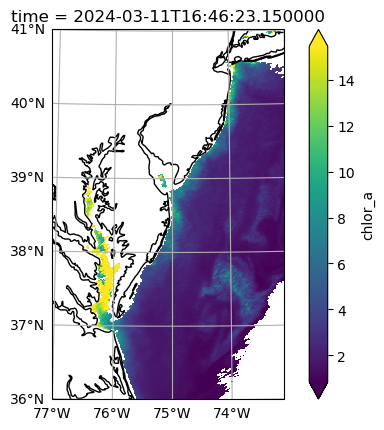

In [45]:
fig = plt.figure()
crs = ccrs.UTM(18, southern_hemisphere=False)
axes = plt.axes(projection=crs)
artist = dataset_t["chlor_a"].plot.imshow(x="x", y="y", robust=True, ax=axes)
axes.gridlines(draw_labels={"left": "y", "bottom": "x"})
axes.coastlines()
plt.show()

Many will not, either because of clouds or because only some portion of the specified bounding box is within the given swath.

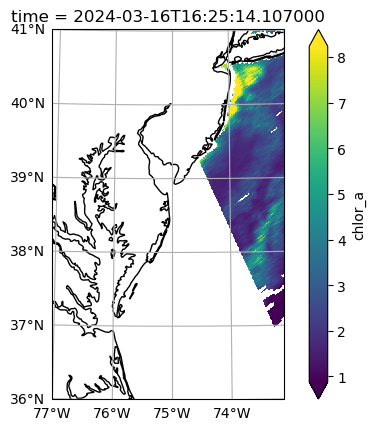

In [46]:
dataset_t = dataset.isel({"time": 8})

fig = plt.figure()
crs = ccrs.UTM(18, southern_hemisphere=False)
axes = plt.axes(projection=crs)
artist = dataset_t["chlor_a"].plot.imshow(x="x", y="y", robust=True, ax=axes)
axes.gridlines(draw_labels={"left": "y", "bottom": "x"})
axes.coastlines()
plt.show()

[back to top](#Contents)